## Adagrad algorithm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

mnist_train = pd.read_csv("mnist_train.csv", header=None)
mnist_test = pd.read_csv("mnist_test.csv", header = None)
n,d = mnist_train.shape
ntest, dtest = mnist_test.shape


y_train = mnist_train.iloc[:,0]
X_train = mnist_train.iloc[:,1:]
X_train /= 255
X_train = np.array(X_train)

y_test = mnist_test.iloc[:,0]
X_test = mnist_test.iloc[:,1:]
X_test /= 255
X_test = np.array(X_test)


y_train = 2*np.array(y_train == 0)-1 # binary classification 
y_test = 2*np.array(y_test == 0)-1 

In [2]:
def hinge_reg_sgd(x, a, b, lamb):
    threshold = b*np.dot(a,x)[0]
    cost = np.maximum(1 - threshold,0)
    return cost + lamb*np.dot(x.T,x)/2


def grad_reg_sgd(x, a, b, lamb, d):
    threshold = b*np.dot(a,x)[0]

    if (threshold >= 1):
        grad = np.zeros(d)
    else:
        grad = -b*a

    return grad.reshape(d,) + lamb*x


def hingereg(x, a, b, lamb):
    threshold = np.multiply(np.dot(a,x), b) 
    cost = np.maximum(1 - threshold,0)
    return cost.mean() + lamb*np.dot(x.T,x)/2



def gradreg(x, a, b, lamb):
    n,d = a.shape
    threshold = np.multiply(np.dot(a,x) , b)
    grad = -np.multiply(a, b.reshape(b.shape[0],1))
    idx_zeros = (threshold >= 1)
    grad[idx_zeros,:] = np.zeros(d)
    return grad.sum(axis=0)/n + lamb*x



def proj_simplex(x, z=1):

    d = x.shape[0]
    x_sorted = -np.sort(-x) 
    x_cumsum = np.cumsum(x_sorted)
    find = x_sorted - (1/np.arange(1,d+1,1))*(x_cumsum - z)
    d0 = np.argmax(find <= 0) #+ 1
    theta_star = (1/d0)*(x_cumsum[d0-1] - z)

    return np.maximum(x-theta_star,0)


def proj_l1(x, z=1):
    x_abs = np.absolute(x)
    if (np.sum(x_abs) > z):
        p_simplex = proj_simplex(x_abs, z)
        sgn = 2*(x>0)-1
        x = np.multiply(sgn, p_simplex)    
    return x



def proj_l1_w(x,w,z=1):
    v = abs(x* w)
    u = np.argsort(-v)
  
    sx = np.cumsum(abs(x)[u])
    sw = np.cumsum(1/w[u])
    
    rho = np.argmax(v[u] - (sx-z) / sw <= 0) - 1
    theta = (sx[rho] -z) / sw[rho]
    
    x_simplex = np.maximum(abs(x) - theta/w, 0)
    x_abs = np.absolute(x)
    if (np.sum(x_abs) > z):
        sgn = np.sign(x)
        x = np.multiply(sgn, x_simplex)  
        
    return x

In [3]:
def Adagrad(a, b, iters, cost,  grad, lamb, X_test = None, y_test = None, z=100):

    start_time = time.time()
    n,d = a.shape
    
    indices = np.random.randint(0,n,iters)
    params = []
    costs = []
    test_scores = []
    
    xt = np.zeros(d)
    st = np.ones(d)*(1/(4*d))
    params.append(xt)
    p_mean = np.zeros(d)
    eta = 1/(lamb * np.sqrt(iters))
    
    
    for i in range(1,iters+1):
        
        # Random indice
        x_i = a[indices[i-1],:].reshape(1,d)
        y_i = b[indices[i-1]]
        
        # Adagrad update
        grad_t = grad(params[-1], x_i, y_i, lamb, d)
        st += grad_t**2
        lr = eta/np.sqrt(st)
        yt = xt - np.multiply(lr, grad_t)
        # Projection step
        xt = proj_l1_w(yt, np.sqrt(st), z)
        
        # Save
        p_mean += xt
        params.append(xt)
        c = hingereg(xt, a, b, lamb)
        costs.append(c)
        test_score = (np.multiply(np.matmul(X_test,p_mean/i), y_test) > 0).mean() 
        test_scores.append(test_score)
    
    
    end_time = time.time()
    print("Time of execution : %s seconds" % (end_time - start_time)) 
    return params, costs, np.array(test_scores)

Time of execution : 5.5509352684021 seconds
max test scores : 0.972
last test scores : 0.966


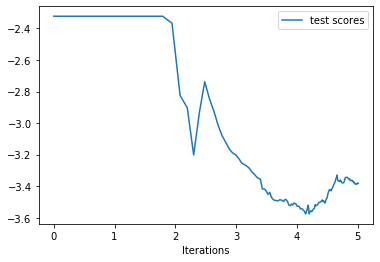

In [4]:
niter = 150
lamb = 1/3
z= 100
params_ada, costs_ada, test_scores_ada = Adagrad(X_train, y_train, niter, hinge_reg_sgd, grad_reg_sgd, lamb, X_test, y_test, z)

# Convergence on test dataset
print("max test scores : {}".format(np.amax(test_scores_ada)))
print("last test scores : {}".format(test_scores_ada[-1]))
plt.plot(np.log(range(1, niter+1)), np.log(1-np.array(test_scores_ada)), label = "test scores")
plt.xlabel("Iterations")
plt.legend()
plt.show()

#### Hyperparameters optimization

In [5]:
def opt_ada(xtrain, ytrain, xtest, ytest):
    best_score = -np.inf
    best_l = 0
    best_z = 0
    
    niter = 100 
    list_l = [0.001, 0.01, (1/3), 1]
    list_z = [10,100,1000,10000]

    for l in list_l:
        for z in list_z:
            x0 = np.zeros(784) 
            _, _, test_scores = Adagrad(xtrain, ytrain, niter, hinge_reg_sgd, grad_reg_sgd, l, xtest, ytest, z)
            last_score = test_scores[-10:].mean()
            print("Lambda = {}, z = {}, score = {}".format(l, z, last_score), "\t")
            if (last_score >= best_score):
                best_score = last_score
                best_l = l
                best_z = z
                
            
    return best_l, best_z

In [ ]:
best_l, best_z = opt_ada(X_train, y_train, X_test, y_test)
print("Best parameters founded : ")
print("z = {} and lr = {}".format(best_z, best_l))